# Performance evaluation and benchmarking

In this notebook we will go step-by-step through the model evaluation part of our paper, where we compare the predictions of the XGBoost and EA-LSTM models.

Note:
If you want to run this notebook locally and reproduce the figures of our paper
- make sure you have the models' predictions. See the `README.md` in the repository for further instructions.

- make sure to have the CAMELS benchmark data set. See the `README.md` in the repository for further instructions.

#### Adapt the lines below according to your local system

In [1]:
# Needed if no precomputed results are used. Main directory containing all runs
BASE_RUN_DIR = "/home/mgauch/ealstm_regional_modeling/runs/run_grid_3010_2119/"

# Path to CAMELS data
CAMELS_DIR = "/home/mgauch/ealstm_regional_modeling/data/CAMELS"

# Path to the main directory of this repository
BASE_CODE_DIR = "/home/mgauch/ealstm_regional_modeling"

In [2]:
# Imports
import pickle
import sys
from collections import defaultdict
from pathlib import Path
import itertools
import os

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import pandas as pd
import tqdm
from scipy.stats import wilcoxon, ks_2samp

# Add repository to Python path
sys.path.append(BASE_CODE_DIR)
from papercode.plotutils import (model_draw_style, model_specs_gridEvaluation, 
                                 ecdf, get_shape_collections)
from papercode.evalutils import (get_run_dirs_gridEvaluation, eval_datadriven_models, 
                                 eval_benchmark_models, get_pvals, 
                                 get_mean_basin_performance, get_cohens_d)
from papercode.datautils import load_attributes, add_camels_attributes
from papercode.utils import get_basin_list

from papercode.metrics import *

Definition of global variables. 

**Note**: If you want to recompute all model metrics, change the `PRECOMPUTED_DATA` flag to `False`. No GPU is required. If you want to use the pre-calculated metrics, make sure the flag is set to `True`

In [3]:
# If True load pre-computed metrics from pickle file, else re-calculate everything
PRECOMPUTED_DATA = True

# Convert to PosixPaths
BASE_RUN_DIR = Path(BASE_RUN_DIR)
BASE_CODE_DIR = Path(BASE_CODE_DIR)
CAMELS_DIR = Path(CAMELS_DIR)

# Set of evaluation functions
EVAL_FUNCS = {'NSE': calc_nse, 
              'alpha_nse': calc_alpha_nse, 
              'beta_nse': calc_beta_nse,
              'FHV': calc_fdc_fhv, 
              'FLV': calc_fdc_flv, 
              'FMS': calc_fdc_fms}

# Evaluate data-driven models

First, we compare the XGBoost models with EA-LSTM models on different amounts of training data. There are nine different setups, resulting from the combinations of the following dimensions:

1. Number of training years: 3, 6, or 9
2. Number of basins: 13, 26, 53, 265, or 531

For each of the 3*5 settings, we trained 8 models (using different random initializations). We combined these 8 models to an ensemble (by averaging the k=8 model simulations), which is what we evaluate here.

To account for differences in the basins, we evaluate the performance on 13, 26, 53 and 265 basins on five different random basin subsets.

In [4]:
if PRECOMPUTED_DATA:
    print("Loaded data from pre-computed pickle file")
    with open(BASE_RUN_DIR / "all_metrics_gridEvaluation.p", "rb") as fp:
        all_metrics = pickle.load(fp)
else:
    all_metrics = {}
    for func_name, func in EVAL_FUNCS.items():
        tqdm.tqdm.write(f"Calculating metric: {func_name}")
        model_metrics = {}
        for (model, _, _), training_years, n_basins in itertools.product(model_specs_gridEvaluation['models'], 
                                                                 model_specs_gridEvaluation['training_years'], 
                                                                 model_specs_gridEvaluation['n_basins']):
            if not model in model_metrics: 
                model_metrics[model] = {}
            if not training_years in model_metrics[model]:
                model_metrics[model][training_years] = {}
            tqdm.tqdm.write(f"Model: {model}, Training years: {training_years}, number of basins: {n_basins}")
            for basin_subset in model_specs_gridEvaluation['basin_subsets'][n_basins]:
                run_dirs = get_run_dirs_gridEvaluation(root_dir=BASE_RUN_DIR, model=model, basin_subset=basin_subset, training_years=training_years)
                model_metrics[model][training_years][basin_subset] = eval_datadriven_models(run_dirs=run_dirs, func=func)

        all_metrics[func_name] = model_metrics

Loaded data from pre-computed pickle file


## Tabular comparison

In a first step, we look at the mean, median NSE as well as the number of catastrophic failures. Catastrophic failures are defined as the number of basins, where the model has a NSE <= 0.
We calculate the mean of each of this three statistics over the model (n=8) model repetitions and the random basin samples and report the standard deviation here as well. The repetitions are denoted as `ensemble=False` in the table below.

In [5]:
data = []
for model, model_label, _ in model_specs_gridEvaluation['models']:
    for training_years, n_basins in itertools.product(model_specs_gridEvaluation['training_years'], 
                                                      model_specs_gridEvaluation['n_basins']):
        ensemble_nses = []
        means, medians, failures, mins, maxs = [], [], [], [], []
        for basin_subset in model_specs_gridEvaluation['basin_subsets'][n_basins]:
            models = all_metrics['NSE'][model][training_years][basin_subset]
            seeds = [k for k in models.keys() if "seed" in k]
            if len(seeds) == 0:
                print(f"No data for {model}, {training_years} years, {n_basins} basins (subset no. {basin_subset})")
                continue
            for seed in seeds:
                values = list(models[seed].values())
                mins.append(np.min(values))
                maxs.append(np.max(values))
                means.append(np.mean(values))
                medians.append(np.median(values))
                failures.append(len([v for v in values if v <= 0]))
            ensemble_nses += list(models["ensemble"].values())
            
        if len(ensemble_nses) == 0:
            print(f"No results for {model}, {training_years} years, {n_basins} basins")
            continue
            
        num_subsets = len(model_specs_gridEvaluation['basin_subsets'][n_basins])
        data_sing = {'model': model_label, 
                     'training_years': training_years,
                     'n_basins': n_basins,
                     'ensemble': False, 
                     'min': np.min(mins), 
                     'max': np.max(maxs), 
                     'mean': np.mean(means), 
                     'std_mean': np.std(means),
                     'median': np.mean(medians),
                     'std_median': np.std(medians),
                     'avg_failures': np.sum(failures) / (len(seeds) * num_subsets),
                     'std_failures': np.std(failures)}
        data.append(data_sing)
        data_ensemble = {'model': model_label, 
                         'training_years': training_years,
                         'n_basins': n_basins,
                         'ensemble': True,
                         'min': np.min(ensemble_nses),
                         'max': np.max(ensemble_nses),
                         'mean': np.mean(ensemble_nses),
                         'median': np.median(ensemble_nses),
                         'avg_failures': len([v for v in ensemble_nses if v <= 0]) / num_subsets}
        data.append(data_ensemble)

df = pd.DataFrame(data)
df = df.set_index(keys=["training_years", "n_basins", "ensemble", "model"])
df.sort_values(by=["training_years","n_basins", "ensemble", "model"], inplace=True)
df[["min", "mean", "median", "avg_failures", "std_mean", "std_median", "std_failures"]]

min      mean    median  \
training_years n_basins ensemble model                                    
3              13       False    EA-LSTM  -1.397067  0.114757  0.150652   
                                 XGBoost  -0.559515  0.301178  0.319213   
                        True     EA-LSTM  -0.260149  0.147755  0.156288   
                                 XGBoost  -0.431334  0.306206  0.324908   
               26       False    EA-LSTM  -1.297110  0.264800  0.280765   
                                 XGBoost  -3.667734  0.348929  0.394060   
                        True     EA-LSTM  -0.086306  0.299730  0.307008   
                                 XGBoost  -2.039548  0.357131  0.401660   
               53       False    EA-LSTM  -1.015852  0.430060  0.452478   
                                 XGBoost  -2.553632  0.438127  0.466102   
                        True     EA-LSTM  -0.118457  0.462638  0.483833   
                                 XGBoost  -1.652938  0.444821  0.471337   
               265      False    EA-LSTM  -5.795502  0.562408  0.606922   
                                 XGBoost  -2.356411  0.500750  0.541381   
                        True     EA-LSTM  -0.233172  0.600707  0.639357   
                                 XGBoost  -1.924580  0.509154  0.549233   
               531      False    EA-LSTM  -2.283731  0.597223  0.640739   
                                 XGBoost  -1.794076  0.520881  0.560167   
                        True     EA-LSTM   0.031266  0.636011  0.680531   
                                 XGBoost  -1.341143  0.528879  0.568288   
6              13       False    EA-LSTM  -0.483846  0.386905  0.406100   
                                 XGBoost  -0.605717  0.427680  0.471717   
                        True     EA-LSTM  -0.073807  0.418537  0.439171   
                                 XGBoost  -0.365288  0.435575  0.486578   
               26       False    EA-LSTM  -0.236959  0.476888  0.507236   
                                 XGBoost  -5.050832  0.446945  0.515710   
                        True     EA-LSTM  -0.046617  0.515597  0.544026   
                                 XGBoost  -4.144493  0.460361  0.528359   
               53       False    EA-LSTM  -0.188340  0.563458  0.598802   
                                 XGBoost  -1.455187  0.538368  0.569118   
                        True     EA-LSTM   0.063587  0.594758  0.625090   
                                 XGBoost  -1.146967  0.546825  0.578642   
               265      False    EA-LSTM  -2.941916  0.636164  0.680973   
                                 XGBoost  -4.960132  0.568214  0.617444   
                        True     EA-LSTM  -0.200890  0.668031  0.707801   
                                 XGBoost  -3.078965  0.577949  0.625611   
               531      False    EA-LSTM  -4.838903  0.651181  0.692963   
                                 XGBoost  -2.590614  0.586254  0.629535   
                        True     EA-LSTM  -1.419325  0.684236  0.719334   
                                 XGBoost  -1.750687  0.595636  0.636779   
9              13       False    EA-LSTM  -0.300032  0.465839  0.484999   
                                 XGBoost  -0.678141  0.471406  0.504808   
                        True     EA-LSTM   0.082297  0.496790  0.516359   
                                 XGBoost  -0.303481  0.479068  0.514889   
               26       False    EA-LSTM  -0.360043  0.539954  0.577576   
                                 XGBoost  -3.713112  0.499519  0.556974   
                        True     EA-LSTM  -0.063569  0.570534  0.604552   
                                 XGBoost  -2.405994  0.510096  0.566572   
               53       False    EA-LSTM  -1.239564  0.602126  0.640402   
                                 XGBoost  -2.180518  0.566804  0.602022   
                        True     EA-LSTM  -0.029655  0.632637  0.669767   
                                 XGBoost  -1.220987  0.576258  0.609782  

## Plot correlation between number of samples and NSE

- Green triangles represent XGBoost, orange triangles represent EA-LSTMs.
- the color shade represents the amount of basins. The darker the color, the more basins.
- The triangle orientation represents the amount of training years. Triangles facing down: 3 years, facing left: 6 years, facing up: 9 years.

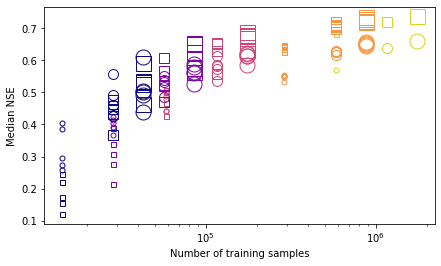

In [6]:
f = plt.figure(figsize=(7,4))

colors = {13: [0.05, 0.03, 0.53], 26:  [0.49, 0.01 , 0.66],
          53: [0.80, 0.28, 0.47], 265: [0.97, 0.59, 0.25],
          531: [0.84, 0.84, 0.13]}
markers = {'xgboost': 'o', 'ealstm': 's'}
markersize = {3: 5, 6: 10, 9: 15}
for model, name, _ in model_specs_gridEvaluation["models"]:
    for training_years, (i, n_basins) in itertools.product(model_specs_gridEvaluation['training_years'], 
                                                      enumerate(model_specs_gridEvaluation['n_basins'])):
        basin_subsets = model_specs_gridEvaluation["basin_subsets"][n_basins]
        median_nses, n_samples = [], []
        for b in basin_subsets:
            median_nses.append(np.median(list(all_metrics['NSE'][model][training_years][b]["ensemble"].values())))
            n_samples.append(training_years * 365 * n_basins)
        plt.plot(n_samples, median_nses, label=f"{name}, {training_years} years, {n_basins} basins", 
                 lw=0, marker=markers[model], c=colors[n_basins], markersize=markersize[training_years], markerfacecolor='none')
    
plt.xscale('log')
plt.ylabel('Median NSE')
_ = plt.xlabel('Number of training samples')

## Plot change of NSE distributions with training set size

This plot aggregates the results from the above plot, and shows boxplots of NSE distributions at different orders of training set size magnitude.

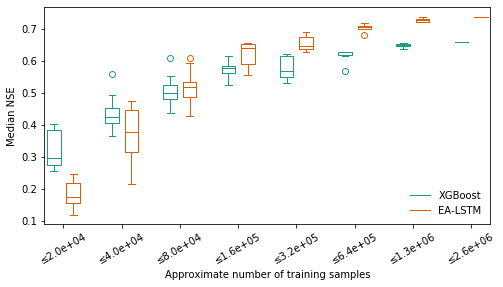

In [7]:
f = plt.figure(figsize=(8,4))

legend = []
for i, (model, name, color) in enumerate(model_specs_gridEvaluation["models"]):
    nse_dict = {20_000: [], 40_000: [], 80_000: [], 160_000: [], 
                320_000: [], 640_000: [], 1_280_000: [], 2_560_000: []}
    for training_years, n_basins in itertools.product(model_specs_gridEvaluation['training_years'], 
                                                      model_specs_gridEvaluation['n_basins']):
        basin_subsets = model_specs_gridEvaluation["basin_subsets"][n_basins]
        for b in basin_subsets:
            nse = np.median(list(all_metrics['NSE'][model][training_years][b]["ensemble"].values()))
            n_samples = training_years * 365 * n_basins
            for magnitude in sorted(nse_dict):
                if magnitude >= n_samples:
                    nse_dict[magnitude].append(nse)
                    break

    bp = plt.boxplot(nse_dict.values(), positions=np.arange(i, 3*len(nse_dict), 3), widths=0.7)
    for prop in ['boxes', 'caps', 'whiskers', 'medians']:
        plt.setp(bp[prop], color=color)
    plt.setp(bp['fliers'], markeredgecolor=color)
    legend.append((bp['boxes'][0], name))
    
plt.ylabel('Median NSE')
plt.xticks(np.arange(0.5,3*len(nse_dict), 3), [f"≤{k:.1e}" for k in nse_dict], rotation=30)
plt.legend(*zip(*legend), frameon=False, loc='lower right')
_ = plt.xlabel('Approximate number of training samples')

## Calculate statistical significance.

Calculate statistical significance between XGBoost and EA-LSTM.

In [8]:
p_values = {}
d_values = {}
for training_years in model_specs_gridEvaluation['training_years']:
    p_values[training_years] = {}
    d_values[training_years] = {}
    for n_basins in model_specs_gridEvaluation['n_basins']:
        print(f"{training_years} training years, {n_basins} basins")
        
        basin_subsets = model_specs_gridEvaluation["basin_subsets"][n_basins]
        xgb_nses = list(all_metrics['NSE']["xgboost"][training_years][s]["ensemble"].values() for s in basin_subsets)
        xgb_nses = [y for x in xgb_nses for y in x]  # flatten
        ealstm_nses = list(all_metrics['NSE']["ealstm"][training_years][s]["ensemble"].values() for s in basin_subsets)
        ealstm_nses = [y for x in ealstm_nses for y in x]  # flatten
        
        _, p_val_ks = ks_2samp(xgb_nses, ealstm_nses)
        _, p_val_wilcoxon = wilcoxon(xgb_nses, ealstm_nses)
        print(f"KS-Test: {p_val_ks:.2e}, Wilcoxon: {p_val_wilcoxon:.2e}")
        
        d_ensemble = get_cohens_d(xgb_nses, ealstm_nses)
        print(f"Effect size: Ensemble mean d={d_ensemble:.3f}")
        
        p_values[training_years][n_basins] = p_val_ks
        d_values[training_years][n_basins] = d_ensemble

3 training years, 13 basins
KS-Test: 9.78e-07, Wilcoxon: 1.06e-09
Effect size: Ensemble mean d=1.010
3 training years, 26 basins
KS-Test: 8.27e-07, Wilcoxon: 3.76e-10
Effect size: Ensemble mean d=0.262
3 training years, 53 basins
KS-Test: 1.47e-01, Wilcoxon: 3.35e-03
Effect size: Ensemble mean d=0.101
3 training years, 265 basins
KS-Test: 2.24e-53, Wilcoxon: 6.88e-154
Effect size: Ensemble mean d=0.457
3 training years, 531 basins
KS-Test: 1.16e-32, Wilcoxon: 2.26e-73
Effect size: Ensemble mean d=0.579
6 training years, 13 basins
KS-Test: 1.95e-01, Wilcoxon: 2.02e-02
Effect size: Ensemble mean d=0.099
6 training years, 26 basins
KS-Test: 4.17e-01, Wilcoxon: 4.34e-03
Effect size: Ensemble mean d=0.169
6 training years, 53 basins
KS-Test: 7.22e-07, Wilcoxon: 1.89e-17
Effect size: Ensemble mean d=0.287
6 training years, 265 basins
KS-Test: 1.63e-55, Wilcoxon: 5.72e-153
Effect size: Ensemble mean d=0.424
6 training years, 531 basins
KS-Test: 7.28e-26, Wilcoxon: 5.78e-70
Effect size: Ensemb

## Cumulative density function plot

Here we look at the CDF of the NSEs for each of our 3*5 configurations.

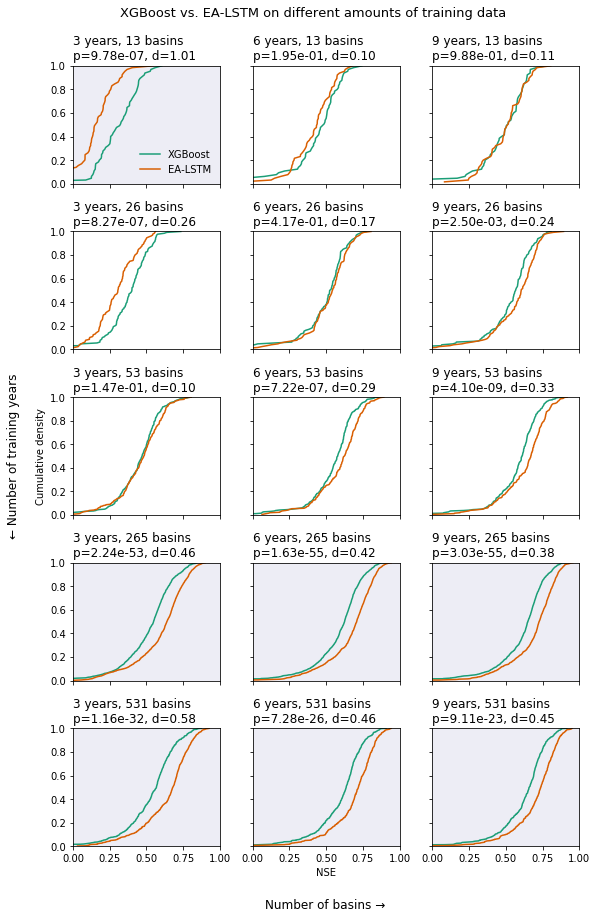

In [9]:
fig, ax = plt.subplots(nrows=5, ncols=3, sharex=True, sharey=True, figsize=(8,12))

for j, training_years in enumerate(model_specs_gridEvaluation['training_years']):
    for i, n_basins in enumerate(model_specs_gridEvaluation['n_basins']):
        ax[i,j].set_xlim(0, 1)
        ax[i,j].set_ylim(0, 1)
        
        for model, model_label, model_color in model_specs_gridEvaluation['models']:
            values = []
            for basin_subset in model_specs_gridEvaluation['basin_subsets'][n_basins]:
                values += list(all_metrics["NSE"][model][training_years][basin_subset]['ensemble'].values())
            bin_, cdf_ = ecdf(values)
            ax[i,j].plot(bin_, cdf_,
                         label=model_label, color=model_color)
            p_val = p_values[training_years][n_basins]
            d_val = d_values[training_years][n_basins]
            if p_val < (0.01 / 15) and d_val > 0.35:  # divide p-value by 15 for Bonferroni correction
                ax[i,j].set_facecolor((0.9,0.9,0.95,0.7))
            ax[i,j].set_title(f"{training_years} years, {n_basins} basins \np={p_val:.2e}, d={d_val:.2f}", 
                              loc='left', fontsize=12)
ax[0,0].legend(loc="lower right", frameon=False)
ax[4,1].set_xlabel('NSE')
ax[2,0].set_ylabel('Cumulative density')
fig.text(0.52, -0.02, 'Number of basins →', ha='center', va='center', fontsize=12)
fig.text(-0.02, 0.5, '← Number of training years', ha='center', va='center', rotation='vertical', fontsize=12)
fig.tight_layout()
_ = plt.suptitle("XGBoost vs. EA-LSTM on different amounts of training data", fontsize=13, fontweight=0, color='black', y=1.02)

## Plot NSE per basin

Here we plot the models' NSE values for each basin in a heatmap, once for the models trained on all nine years and 531 basins, and once for the models trained on three years and 13 basins.

In [10]:
if not os.path.exists(BASE_CODE_DIR / "data" / "attributes.db"):
    add_camels_attributes(CAMELS_DIR)
attributes = load_attributes(db_path=BASE_CODE_DIR / "data" / "attributes.db", basins=get_basin_list(), 
                             drop_lat_lon=False, keep_features=["gauge_lat", "gauge_lon"])

nse_dict_large_train = {'xgboost': all_metrics["NSE"]["xgboost"][9][0]["ensemble"],
                        'ealstm': all_metrics["NSE"]["ealstm"][9][0]["ensemble"]}
nses_large = pd.DataFrame(nse_dict_large_train['xgboost'].values(), index=nse_dict_large_train['xgboost'].keys(), columns=["xgboost"])
nses_large = nses_large.join(pd.Series(nse_dict_large_train['ealstm'], name="ealstm"))
data_large = attributes.join(nses_large)

def merge_basin_predictions(nse_dicts):
    """ Merge a model's NSEs for different basin sets into one dictionary of average NSE per basin """
    nses = {}
    for d in nse_dicts:
        for basin, nse in d.items():
            if basin not in nses:
                nses[basin] = []
            nses[basin].append(nse)
    for basin, nse_list in nses.items():
        nses[basin] = np.mean(nse_list)
    return nses
                
nse_dict_small_train = {'xgboost': merge_basin_predictions([all_metrics["NSE"]["xgboost"][3][basin_subset]["ensemble"] 
                                                            for basin_subset in model_specs_gridEvaluation['basin_subsets'][13]]),
                        'ealstm': merge_basin_predictions([all_metrics["NSE"]["ealstm"][3][basin_subset]["ensemble"] 
                                                           for basin_subset in model_specs_gridEvaluation['basin_subsets'][13]])}

nses_small = pd.DataFrame(nse_dict_small_train['xgboost'].values(), index=nse_dict_small_train['xgboost'].keys(), columns=["xgboost"])
nses_small = nses_small.join(pd.Series(nse_dict_small_train['ealstm'], name="ealstm"))
data_small = attributes.join(nses_small)

vmin = min(data_large['xgboost'].min(),data_large['ealstm'].min(), 
           data_small['xgboost'].min(),data_small['ealstm'].min())

/home/mgauch/miniconda3/envs/ealstm/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mgauch/miniconda3/envs/ealstm/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """


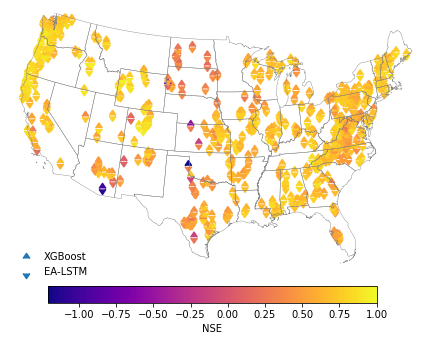

In [11]:
fig, ax = plt.subplots(figsize=(6,5))
m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
shp_info = m.readshapefile(str(BASE_CODE_DIR / 'data/st99_d00'), 'states', 
                           drawbounds=True, linewidth=0.4, color='gray')

x, y = m(data_large["gauge_lon"].values, data_large["gauge_lat"].values)  # transform coordinates
m = ax.scatter(x=x, y=y+5000, s=45, marker=10, c=data_large['xgboost'], 
                cmap='plasma', vmin=vmin, vmax=1, label="XGBoost")
m2 = plt.scatter(x=x, y=y-5000, s=45, marker=11, c=data_large["ealstm"], 
                 cmap='plasma', vmin=vmin, vmax=1, label="EA-LSTM")
ax.axis(False)
plt.legend(frameon=False, loc="lower left")
plt.colorbar(m, ax=ax, pad=0, shrink=.8, orientation='horizontal', label='NSE')
plt.tight_layout()

/home/mgauch/miniconda3/envs/ealstm/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mgauch/miniconda3/envs/ealstm/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """


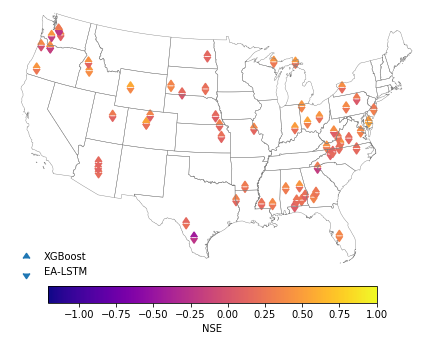

In [12]:
fig, ax = plt.subplots(figsize=(6,5))
m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
shp_info = m.readshapefile(str(BASE_CODE_DIR / 'data/st99_d00'), 'states', 
                           drawbounds=True, linewidth=0.4, color='gray')

x, y = m(data_small["gauge_lon"].values, data_small["gauge_lat"].values)  # transform coordinates
m = ax.scatter(x=x, y=y+5000, s=45, marker=10, c=data_small['xgboost'], 
                cmap='plasma', vmin=vmin, vmax=1, label="XGBoost")
m2 = plt.scatter(x=x, y=y-5000, s=45, marker=11, c=data_small["ealstm"], 
                 cmap='plasma', vmin=vmin, vmax=1, label="EA-LSTM")
ax.axis(False)
plt.legend(frameon=False, loc="lower left")
plt.colorbar(m, ax=ax, pad=0, shrink=.8, orientation='horizontal', label='NSE')
plt.tight_layout()

In [ ]:
if not PRECOMPUTED_DATA:
    with open(BASE_RUN_DIR / "all_metrics_gridEvaluation.p", "wb") as fp:
        pickle.dump(all_metrics, fp)
    print("Stored precomputed data in 'all_metrics_gridEvaluation.p'")

In [13]:
data = []
for model, model_label, _ in model_specs_gridEvaluation["models"]:
    for training_years, n_basins in itertools.product(model_specs_gridEvaluation['training_years'],
                                                      model_specs_gridEvaluation['n_basins']):
        for basin_subset in model_specs_gridEvaluation['basin_subsets'][n_basins]:
            single_model = {'model': model_label, 'ensemble': False,
                            'training_years': training_years,
                            'n_basins': n_basins,
                            'basin_subset': basin_subset}
            ensemble_mean = {'model': model_label, 'ensemble': True,
                             'training_years': training_years,
                             'n_basins': n_basins,
                             'basin_subset': basin_subset}
            # average over single models
            for metric, metric_data in all_metrics.items():
                seeds = [k for k in metric_data[model][training_years][basin_subset].keys() if "seed" in k]
                seed_vals = defaultdict(list)
                for seed in seeds:
                    values = list(metric_data[model][training_years][basin_subset][seed].values())
                    seed_vals[f"{metric} median"].append(np.median(values))
                    if metric == "NSE":
                        seed_vals[f"{metric} mean"].append(np.mean(values))
                        seed_vals["failures"].append(len([v for v in values if v <= 0]))
                    single_model[f"{metric} median"] = np.mean(seed_vals[f"{metric} median"])
                    single_model[f"{metric} median std"] = np.std(seed_vals[f"{metric} median"])
                    if metric == "NSE":
                        single_model[f"{metric} mean"] = np.mean(seed_vals[f"{metric} mean"])
                        single_model[f"{metric} mean std"] = np.std(seed_vals[f"{metric} mean"])
                        single_model[f"failures"] = np.mean(seed_vals["failures"])
                        single_model[f"failures std"] = np.std(seed_vals["failures"])

                # ensemble mean
                values = list(metric_data[model][training_years][basin_subset]["ensemble"].values())
                ensemble_mean[f"{metric} median"] = np.median(values)
                if metric == "NSE":
                    ensemble_mean["NSE mean"] = np.mean(values)
                    ensemble_mean["failures"] = len([v for v in values if v <= 0])
            data.append(single_model)
            data.append(ensemble_mean)
        
df = pd.DataFrame(data)
df = df.set_index(keys=["training_years", "n_basins", "basin_subset", "ensemble", "model"])
df.sort_values(["training_years", "n_basins", "basin_subset", "ensemble", "model"], inplace=True)
df

FHV median  \
training_years n_basins basin_subset ensemble model                 
3              13       16           False    EA-LSTM  -74.724322   
                                              XGBoost  -66.462193   
                                     True     EA-LSTM  -76.132173   
                                              XGBoost  -66.616092   
                        17           False    EA-LSTM  -81.252032   
                                              XGBoost  -66.228046   
                                     True     EA-LSTM  -83.224881   
                                              XGBoost  -66.710682   
                        18           False    EA-LSTM  -76.220268   
                                              XGBoost  -63.202173   
                                     True     EA-LSTM  -76.485334   
                                              XGBoost  -64.319971   
                        19           False    EA-LSTM  -74.480083   
                                              XGBoost  -60.041835   
                                     True     EA-LSTM  -76.745154   
                                              XGBoost  -60.882933   
                        20           False    EA-LSTM  -77.518858   
                                              XGBoost  -55.320312   
                                     True     EA-LSTM  -79.238823   
                                              XGBoost  -56.211224   
               26       11           False    EA-LSTM  -63.998624   
                                              XGBoost  -55.185761   
                                     True     EA-LSTM  -64.926029   
                                              XGBoost  -55.896249   
                        12           False    EA-LSTM  -52.023631   
                                              XGBoost  -50.592492   
                                     True     EA-LSTM  -54.669438   
                                              XGBoost  -51.107923   
                        13           False    EA-LSTM  -61.901890   
                                              XGBoost  -56.254720   
...                                                           ...   
9              53       9            True     EA-LSTM  -25.243888   
                                              XGBoost  -32.919632   
                        10           False    EA-LSTM  -23.218034   
                                              XGBoost  -32.686641   
                                     True     EA-LSTM  -24.593847   
                                              XGBoost  -32.681354   
               265      1            False    EA-LSTM  -18.213230   
                                              XGBoost  -28.217594   
                                     True     EA-LSTM  -19.190300   
                                              XGBoost  -28.524719   
                        2            False    EA-LSTM  -18.589298   
                                              XGBoost  -27.974459   
                                     True     EA-LSTM  -19.303852   
                                              XGBoost  -28.331430   
                        3            False    EA-LSTM  -15.979744   
                                              XGBoost  -26.519468   
                                     True     EA-LSTM  -17.948238   
                                              XGBoost  -26.509073   
                        4            False    EA-LSTM  -18.667094   
                                              XGBoost  -28.426055   
                                     True     EA-LSTM  -19.927106   
                                              XGBoost  -28.455486   
                        5            False    EA-LSTM  -16.816815   
                                              XGBoost  -27.535254   
                                     True     EA-LSTM  -17.837878   
                                              XGBoost